# Saliency in Postgres

Since DuckDB's performance is not good for the saliency query, let's check if it
is any better in postgres.

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import utils.duckdb as db
import pandas as pd
import copy
import os

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64 // 4, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net()
model.load_state_dict(torch.load('models/mnist_cnn.pt', weights_only=True))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Make sure to have a psql instance running:

```
docker run --rm --name postgres -p 5432:5432 -e POSTGRES_PASSWORD=pass postgres
```

In [2]:
import psycopg2

con = psycopg2.connect(database="postgres",
                        host="127.0.0.1",
                        user="postgres",
                        password="pass",
                        port="5432")

In [3]:
cursor = con.cursor()
cursor.execute("SELECT 1+1")
cursor.fetchone()

(2,)

Looks good, now we'll adapt the duckdb import script to postgres.

In [4]:
def get_contributing_points(output_point, kernel_size, stride=1, padding=0):
    """
    Given an output point (of the image after convolution), calculates which
    points of the input image contributed. They are returned, along with the
    corresponding kernel location.
    """

    x_out, y_out = output_point
    x_in_start = x_out * stride - padding
    y_in_start = y_out * stride - padding

    contributing_points = []
    for i in range(kernel_size):
        for j in range(kernel_size):
            x_in = x_in_start + i
            y_in = y_in_start + j
            contributing_points.append(((x_in, y_in), (i, j)))

    return contributing_points

In [5]:
import tempfile
import csv

state_dict = model.state_dict()

cursor.close()
cursor = con.cursor()

cursor.execute("DROP TABLE IF EXISTS edge")
cursor.execute("DROP TABLE IF EXISTS node")
cursor.execute("DROP TABLE IF EXISTS input")

cursor.execute(
    """
    CREATE TABLE node(
        id SERIAL PRIMARY KEY,
        bias REAL,
        name TEXT
    )"""
)
cursor.execute(
    """
    CREATE TABLE edge(
        src INTEGER,
        dst INTEGER,
        weight REAL
    )"""
)
cursor.execute(
    """
    CREATE TABLE input(
        input_set_id INTEGER,
        input_node_idx INTEGER,
        input_value REAL
    )"""
)

# We have to hardcode this
input_size = 28

state_dict = model.state_dict()
_, conv1_kernel_size, _ = state_dict['conv1.weight'][0].size()

node_idx = 0
nodes = {}

conv1_weight = state_dict['conv1.weight']
conv1_bias = state_dict['conv1.bias']
conv1_output_size = input_size - conv1_kernel_size + 1

conv1_out_channels, conv1_in_channels, conv1_kernel_size, _ = conv1_weight.size()
if conv1_in_channels != 1:
    raise Exception("Not handling >1 input channels for now")

conv2_weight = state_dict['conv2.weight']
conv2_bias = state_dict['conv2.bias']

conv2_out_channels, conv2_in_channels, conv2_kernel_size, _ = conv2_weight.size()
conv2_output_size = conv1_output_size - conv2_kernel_size + 1

fc1_weight = state_dict['fc1.weight']
fc1_output_size, fc1_input_size = fc1_weight.size()

fc2_weight = state_dict['fc2.weight']
fc2_output_size, fc2_input_size = fc2_weight.size()

with tempfile.NamedTemporaryFile(
    delete=True, mode="w+", newline="", suffix=".csv"
) as tmpfile:
    csv_name = tmpfile.name
    writer = csv.writer(tmpfile)

    # Input nodes (1 channel for now)
    for y in range(0, input_size):
        for x in range(0, input_size):
            name = f"input.{x}.{y}"
            writer.writerow([node_idx, 0, name])
            node_idx += 1
            nodes[name] = node_idx

    # Conv1
    for y in range(0, conv1_output_size):
        for x in range(0, conv1_output_size):
            for c in range(0, conv1_out_channels):
                name = f"conv1.{c}.{x}.{y}"
                # The bias of this layer is simply the bias of the corresponding
                # kernel
                bias = conv1_bias[c]

                writer.writerow([node_idx, bias.item(), name])
                node_idx += 1
                nodes[name] = node_idx

    # Conv2
    for y in range(0, conv2_output_size):
        for x in range(0, conv2_output_size):
            for c in range(0, conv2_out_channels):
                name = f"conv2.{c}.{x}.{y}"
                bias = conv2_bias[c]

                writer.writerow([node_idx, bias.item(), name])
                node_idx += 1
                nodes[name] = node_idx

    # fc1
    for i in range(0, fc1_output_size):
        name = f"fc1.{i}"
        bias = state_dict['fc1.bias'][i]
        writer.writerow([node_idx, bias.item(), name])
        node_idx += 1
        nodes[name] = node_idx

    # fc2
    for i in range(0, fc2_output_size):
        name = f"fc2.{i}"
        bias = state_dict['fc2.bias'][i]
        writer.writerow([node_idx, bias.item(), name])
        node_idx += 1
        nodes[name] = node_idx

    # Flush
    tmpfile.flush()
    tmpfile.seek(0)
    cursor.copy_from(tmpfile, 'node', sep=',')

with tempfile.NamedTemporaryFile(
    delete=True, mode="w+", newline="", suffix=".csv"
) as tmpfile:
    csv_name = tmpfile.name
    writer = csv.writer(tmpfile)

    # Add the edges from input to conv1. Per channel, per output pixel of the
    # convolution, we have to match the 9 input pixels to it (for a 3x3 kernel)
    for c in range(0, conv1_out_channels):
        for y_conv in range(0, conv1_output_size):
            for x_conv in range(0, conv1_output_size):
                # (x_conv, y_conv) is the position in the output channel. We can
                # find the 9 matching input values from them.
                for (p_in, p_kernel) in get_contributing_points((x_conv, y_conv), conv1_kernel_size):
                    (x_in, y_in) = p_in
                    (x_kernel, y_kernel) = p_kernel

                    # 0 corresponds to the input channel (which we only have one
                    # of).
                    kernel = conv1_weight[c][0]
                    weight = kernel[y_kernel][x_kernel]

                    src = nodes[f"input.{x_in}.{y_in}"]
                    dst = nodes[f"conv1.{c}.{x_conv}.{y_conv}"]

                    writer.writerow([src, dst, weight.item()])


    # Add the edges from conv1 to conv2. This is similar as connecting the input to
    # conv1, except that we have 2 input channels. Outputs are summed per output
    # channel.
    for c_out in range(0, conv2_out_channels):
        for y_conv2 in range(0, conv2_output_size):
            for x_conv2 in range(0, conv2_output_size):
                for (p_in, p_kernel) in get_contributing_points((x_conv2, y_conv2), conv2_kernel_size):
                    (x_in, y_in) = p_in
                    (x_kernel, y_kernel) = p_kernel

                    for c_in in range(0, conv2_in_channels):
                        kernel = conv2_weight[c_out][c_in]
                        weight = kernel[y_kernel][x_kernel]

                        src = nodes[f"conv1.{c_in}.{x_in}.{y_in}"]
                        dst = nodes[f"conv2.{c_out}.{x_conv2}.{y_conv2}"]

                        writer.writerow([src, dst, weight.item()])

    # Connect conv2 to fc1.
    for c in range(0, conv2_out_channels):
        for y_conv in range(0, conv2_output_size):
            for x_conv in range(0, conv2_output_size):
                for i in range(0, fc1_output_size):
                    # By adding the channel offset, we flatten.
                    channel_offset = c * conv2_output_size * conv2_output_size
                    weight = fc1_weight[i][y_conv * conv2_output_size + x_conv + channel_offset]

                    src = nodes[f"conv2.{c}.{x_conv}.{y_conv}"]
                    dst = nodes[f"fc1.{i}"]

                    writer.writerow([src, dst, weight.item()])

    # Connect fc1 to fc2.
    for i in range(0, fc2_input_size):
        for j in range(0, fc2_output_size):
            weight = fc2_weight[j][i]

            src = nodes[f"fc1.{i}"]
            dst = nodes[f"fc2.{j}"]


            writer.writerow([src, dst, weight.item()])

    tmpfile.flush()
    tmpfile.seek(0)
    cursor.copy_from(tmpfile, 'edge', sep=',')

And see how it performs on an image.

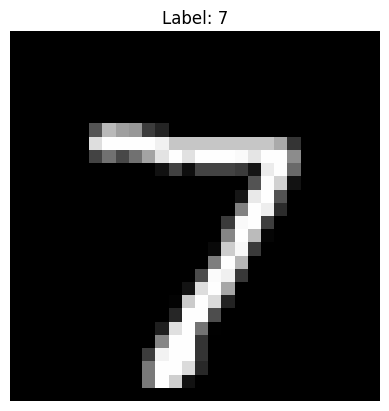

In [6]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

dataset = datasets.MNIST('../data', train=False)
image, label = dataset[0]

image = transforms.ToTensor()(image)
image_np = image.squeeze().numpy()

plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')  # Turn off axis
plt.show()

In [7]:
def load_image_into_input_table(image):
    cursor.execute("TRUNCATE input")
    for i, pixel in enumerate(image.flatten()):
        cursor.execute(f"""
            INSERT INTO input (input_set_id, input_node_idx, input_value)
            VALUES (0, {i + 1}, {pixel.item()})
        """)

load_image_into_input_table(image)

with open('queries/saliency.sql') as file:
    saliency_query = file.read()

cursor.execute(saliency_query)
cursor.fetchall()

InvalidRecursion: aggregate functions are not allowed in a recursive query's recursive term
LINE 45:             n.bias + SUM(e.weight * tx.value)
                              ^
